In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense, AveragePooling2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.regularizers import L2


The input pipeline

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

In [ ]:
# Input Pipeline

# Hyperparameters
batch_size = 64
prefetch_size = tf.data.experimental.AUTOTUNE

# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset_images = tf.data.Dataset.from_tensor_slices(train_images)

#we normalize our data and center the pixel values around zero
train_dataset_images_centered = train_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

train_dataset_targets = tf.data.Dataset.from_tensor_slices(train_labels)
# we want the labels to be onehot encoded
train_dataset_targets = train_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))


# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images_centered, train_dataset_targets))
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(prefetch_size)

# repeat for the test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_images_centered = test_dataset_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))
test_dataset_targets = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.reshape(tf.one_hot(t, 10), (-1,)))

test_dataset = tf.data.Dataset.zip((test_dataset_images_centered, test_dataset_targets))
test_dataset = test_dataset.shuffle(buffer_size=128)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(prefetch_size)

**TransitionLayer** for DenseNet

The transition layer is called inbetween Dense Blocks to reduce the size of the input. Therefore the number of feature maps grows in each DenseBlock, but in between Blocks the pooling is used to reduce the size of the feature maps. That way the later layers learn to identify more highlevel features.


In [ ]:
class TransitionLayer(tf.keras.layers.Layer):
  def __init__(self, bottle_neck):
    super(TransitionLayer, self).__init__()

    # list of 
    self.layers_list = [
                     Conv2D(filters= bottle_neck, kernel_size=(1,1), activation = None, kernel_regularizer = L2()), 
                     BatchNormalization(),
                     Activation('relu'),
                     AveragePooling2D()
    ]
    
  def call(self, x, training = False): 
    for layer in self.layers_list: 
      x = layer(x, training = training)
    return x

**Dense Block** 

DenseBlock, where the block depth is the number of convolutional layers. After each convolutional layer we do a batch normalization. 
After each convolutional layer we append the created feature maps to the input, therefore the dimension of the input grows by the number of filters, also called the growth rate.


In [ ]:
class DenseBlock(tf.keras.layers.Layer):
  def __init__(self, block_depth= 5, p = .2, growth_rate = 16):
    super(DenseBlock, self).__init__()
    self.layers_list = []
    self.batch_list = []

    ## dense block Convolution layer with depth, 16 so every time 
    for i in range(block_depth):
      self.layers_list.append(Conv2D(filters= growth_rate, kernel_size=(3,3), activation= None, padding= 'same', kernel_regularizer= L2())), 
      self.batch_list.append(BatchNormalization())
    
    self.activation = Activation('relu')
    self.Dropout = Dropout(p)
    self.concat = tf.keras.layers.Concatenate()

  def call(self, input, training = False):
    x = input
    for layer, batch_layer in zip(self.layers_list, self.batch_list):
      y = layer(x, training = training)
      y = batch_layer(y)
      x = self.concat([x, y])
    x = self.activation(x)
    x = self.Dropout(x)
    return x

**DenseNet** 

Implementing the densely connected Neural Network.
This architecture allows for deeper models, by connecting the activation of each convolutional layer in the dense block to each of the following layers. This helps against vanishing gradients, since the original input is kept throughout each block

In [ ]:
class DenseNet(tf.keras.Model):
  def __init__(self, block_num= 3, block_depth= 4, growth_rate = 16):
    super(DenseNet, self).__init__()

    self.layers_list = [
                        
          # Our data augmentation
          layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(32,32,3)),
          layers.experimental.preprocessing.RandomRotation(0.1),
          layers.experimental.preprocessing.RandomZoom(0.1),

          # Convolutional Filter 
          Conv2D(filters= (64), kernel_size= 3, padding= 'same', activation = None, kernel_regularizer= L2(), input_shape =(32,32,3)), 
          BatchNormalization(), 
          Activation('relu')
    ]
    for i in range(block_num - 1):
      self.layers_list.append(DenseBlock(block_depth= block_depth))
      self.layers_list.append(TransitionLayer(bottle_neck= (growth_rate * block_depth)))

    self.layers_list.append(DenseBlock(block_depth= block_depth))

    self.global_average  = (GlobalAveragePooling2D())
    self.dense = (Dense(units= 10, activation= 'softmax'))

  def call(self, x, training = False): 
    for layer in self.layers_list: 
      x = layer(x, training = training)

    x = self.global_average(x)
    x = self.dense(x)
    return x

Stolen Train Step

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

Training (stolen as well) 

In [ ]:
from IPython.display import clear_output

def plot_performance(total_epochs, train_loss, test_loss, accuracies, timing):
    """Helper function to plot the models performance inline during and after training"""
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    # Estimation for remaining time
    epoch = len(train_loss) - 1
    remaining_time = (timing[1] - timing[0]) * (total_epochs - epoch)
    fig.suptitle(f"Epoch {epoch} / {total_epochs} - Remaining Training Time: {time.strftime('%M:%S', time.gmtime(remaining_time))} min", fontsize=16)

    ax[0].plot(train_loss)
    ax[0].plot(test_loss)
    ax[0].legend(["training", "test"])
    ax[0].set(xlabel="Training Steps", ylabel="Loss")
    ax[1].plot(accuracies)
    ax[1].set(xlabel="Training Steps", ylabel="Accuracy", title=f"max accuracy: {max(accuracies)*100:.2f}%")

    plt.show()


**Training for DenseNet**

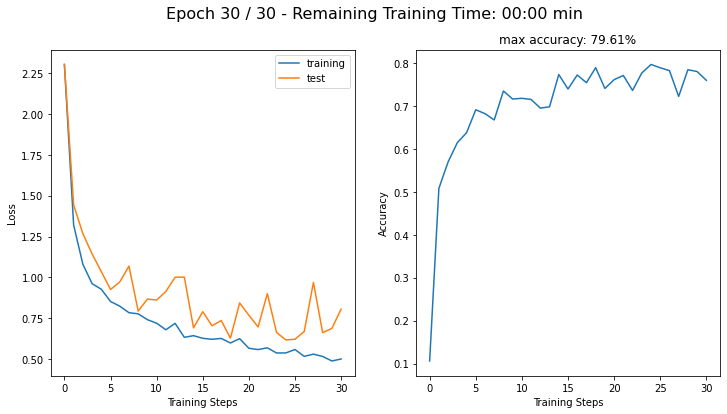

In [9]:
import time
%matplotlib inline
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

# Initialize the model.
model =  DenseNet(block_num= 4)
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    start = time.perf_counter()
    
    #print('Epoch: __ ' + str(epoch))
    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    end = time.perf_counter()
    plot_performance(num_epochs, train_losses, test_losses, test_accuracies, (start, end))


In [10]:
model.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     multiple                  0         
_________________________________________________________________
random_rotation (RandomRotat multiple                  0         
_________________________________________________________________
random_zoom (RandomZoom)     multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  50